In [233]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader


# import torch.optim as optim
import sys
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.append(os.path.abspath(os.path.expanduser("~/DON")))


'''
import argparse
parser = argparse.ArgumentParser(description="DeepONet with configurable parameters.")
parser.add_argument('--problem', type=str, default="heat", help='Problem to solve')
parser.add_argument('--var', type=int, default=0, help='Variant of DeepONet')
parser.add_argument('--visc', type=float, default=0.0001, help='Viscosity')
parser.add_argument('--struct', type=int, default=1, help='Structure of DeepONet')
parser.add_argument('--sensor', type=int, default=50, help='Number of sensors')
parser.add_argument('--boundary_parameter', type=float, default=0, help='Weight parameter for boundary conditions')
parser.add_argument('--initial_parameter', type=float, default=0, help='Weight parameter for initial conditions')
parser.add_argument('--train_batch_size', type=int, default=8000, help='Train Batch size')
parser.add_argument('--test_batch_size', type=int, default=2000, help='Train Batch size')
# 解析命令行参数
args = parser.parse_args()
problem = args.problem
var = args.var
visc = args.visc
struct = args.struct
n_points = args.sensor
boundary_parameter = args.boundary_parameter
initial_parameter = args.initial_parameter
train_batch_size = args.train_batch_size
test_batch_size = args.test_batch_size
'''
problem = "burgers"
var = 0
visc = 0.0001
struct = 1
n_points = 101
boundary_parameter = 0
initial_parameter = 0
train_batch_size = 10000

#test_batch_size = 2000
# epochs = 2
## 需要修改

In [234]:
# In this cell, we define the configurable parameters for the DeepONet

temporal_limit = 1
temporal_step = 0.01

if problem=="heat":
    temporal_start = temporal_step
    total_temporal_steps = int(temporal_limit / temporal_step)
    from utilities.tools import get_cell_centers
    evaluating_points = get_cell_centers(n_points=n_points)
elif problem=="burgers":
    temporal_start = 0
    total_temporal_steps = (int(temporal_limit / temporal_step) + 1)
    evaluating_points = np.linspace(0, 1, n_points)

evaluating_points = np.around(evaluating_points, decimals=2)

total_sample = 500
border = int(total_sample * 4 / 5) # 设置训练集和测试集的边界


# Hyperparameters
branch_input_dim = n_points  # Number of points to represent the original function
trunk_input_dim = 2     # Coordinate where we evaluate the transformed function

# Define the dictionary mapping struct values to neural network structures
if var!=6:
    structures = {
        1: {'hidden_dims': [100, 100, 100, 100], 'output_dim': 50},
        2: {'hidden_dims': [200, 200, 200, 200], 'output_dim': 50}
    }

    # Get the configuration based on the struct value
    config = structures.get(struct, {'hidden_dims': [], 'output_dim': 0})

    hidden_dims = config['hidden_dims']
    output_dim = config['output_dim']
elif var==6:
    structure_params = {
        1: (4, 4, 100, 50),
        2: (4, 4, 200, 50),
    }
    if struct in structure_params:
        branch_depth, trunk_depth, hidden_dim, output_dim = structure_params[struct]
    else:
        raise ValueError("Invalid structure type")

In [235]:
# Define the current directory
from pathlib import Path
# Get the current directory
current_dir = Path.cwd()
model_train_directory = os.path.join(current_dir, '1d_train')
model_stat_file = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}_stat.txt")

In [236]:
# In this cell, we import the function to get the cell centers of a 1D mesh.
# Also, we set up the spatial and temporal grid points for the training and testing datasets.
# This is the so-called y_expanded tensor.
temporal_steps = np.arange(temporal_start, temporal_limit + temporal_step, temporal_step)
temporal_steps = np.around(temporal_steps, decimals=2)

Y1, Y2 = np.meshgrid(evaluating_points, temporal_steps)  # 第一个变量进行行展开，第二个变量进行列展开

y = np.column_stack([Y2.ravel(),Y1.ravel()])
# 先将 Y2 和 Y1 进行展开，然后将展开后的两个向量进行列合并

y_tensor = torch.tensor(y, dtype=torch.float)
print(f"The dimension of y_tensor is {y_tensor.shape}.")
y_expanded = y_tensor.unsqueeze(0).expand(total_sample, -1, -1)
print(f"The dimension of y_expanded is {y_expanded.shape} after expanding.")
print("The zero coordinate of y_expanded is temporal and the first coordinate is space.")

The dimension of y_tensor is torch.Size([10201, 2]).
The dimension of y_expanded is torch.Size([500, 10201, 2]) after expanding.
The zero coordinate of y_expanded is temporal and the first coordinate is space.


In [237]:
# In this cell, we load the initial conditions and solutions from the saved files.

# Define the directory where you want to save the file
from pathlib import Path
# Get the current directory
current_dir = Path.cwd()
#data_directory = os.path.join(current_dir.parent, 'data')
## 需要修改
data_directory = os.path.join(current_dir, 'data')
initials_name = f'{problem}_initials_{visc}_{len(evaluating_points)}.npy'
solutions_name = f'{problem}_solutions_{visc}_{len(evaluating_points)}.npy'

# Define the file paths
initials_path = os.path.join(data_directory, initials_name)
solutions_path = os.path.join(data_directory, solutions_name)

# Load the data
initials = np.load(initials_path)
solutions = np.load(solutions_path)

print(f"The dimensions of the initial conditions are: {initials.shape}")
print(f"The dimensions of the solutions are: {solutions.shape}")

The dimensions of the initial conditions are: (500, 101)
The dimensions of the solutions are: (500, 101, 101)


In [238]:
# In this cell, we arrange the initial conditions into the desired format for training the DeepONet.
# This is the so-called u_expanded tensor.
u_tensor = torch.tensor(initials, dtype=torch.float)
print(f"The dimension of u_tensor is {u_tensor.shape}.")

u_expanded = u_tensor.unsqueeze(1) # u_expanded: tensor[total_sample, 1, n_points]
u_expanded = u_expanded.expand(-1, total_temporal_steps * n_points, -1) # u_expanded: tensor[total_sample, total_temporal_steps*n_points, n_points]
print(f"The dimension of u_expanded is {u_expanded.shape} after expanding.")

The dimension of u_tensor is torch.Size([500, 101]).
The dimension of u_expanded is torch.Size([500, 10201, 101]) after expanding.


In [239]:
# I have a tensor of shape (total_sample, n_points) representing the initial conditions. In this cell, I wanted to expand it to (total_sample, total_temporal_steps*n_points) by repeating the initial conditions for each temporal step.

# Assuming u_tensor is the tensor of shape (total_sample, n_points)
# Expand the tensor to (total_sample, total_temporal_steps*n_points)
u_corresponding = u_tensor.repeat(1, total_temporal_steps)
u_corresponding = u_corresponding.unsqueeze(2) # This is the so-called corresponding initial value

# Take the spatial coordinate of the y_expanded tensor
y_space = y_expanded[:, :, 1].unsqueeze(-1)

In [240]:
# In this cell, we modify the input of the DeepONet based on the variant chosen.
# We also update the input dimensions of the DeepONet based on the variant chosen.
if var==2 or var==3:
    y_expanded = torch.cat((y_expanded, u_corresponding), dim=-1)
elif var==4:
    y_expanded = torch.cat((y_expanded, u_expanded), dim=-1)

if var== 1 or var==3 or var==4:
    u_expanded = torch.cat((u_expanded, y_space), dim=-1)

var_mapping = {
    1: {'var_branch_input_dim': branch_input_dim + 1, 'var_trunk_input_dim': trunk_input_dim},
    2: {'var_branch_input_dim': branch_input_dim, 'var_trunk_input_dim': trunk_input_dim + 1},
    3: {'var_branch_input_dim': branch_input_dim + 1, 'var_trunk_input_dim': trunk_input_dim + 1},
    4: {'var_branch_input_dim': branch_input_dim + 1, 'var_trunk_input_dim': trunk_input_dim + branch_input_dim}
}

if var in var_mapping:
    branch_input_dim = var_mapping[var]['var_branch_input_dim']
    trunk_input_dim = var_mapping[var]['var_trunk_input_dim']

In [241]:
# In this cell, we arrange the solutions into the desired format for training the DeepONet.
# This is the so-called s_expanded tensor.

solutions_linear = np.zeros((total_sample, total_temporal_steps * n_points))

for i in range(total_sample):
    solutions_linear[i] = solutions[i].flatten()

# solutions is a 3D array of shape (total_sample, total_temporal_steps, n_points)
print(f"The loaded solution dataset has dimension {solutions.shape},\n\t while the arranged linearized dataset has dimension {solutions_linear.shape}.")

s_tensor  = torch.tensor(solutions_linear, dtype=torch.float) # s_tensor: tensor[total_sample, total_temporal_steps*n_points]
s_expanded  = s_tensor.unsqueeze(2) # s_expanded: tensor[total_sample, total_temporal_steps*n_points, 1]

print(f"The dimension of s_tensor is {s_tensor.shape}.")
print(f"The dimension of s_expanded is {s_expanded.shape} after expanding.")

The loaded solution dataset has dimension (500, 101, 101),
	 while the arranged linearized dataset has dimension (500, 10201).
The dimension of s_tensor is torch.Size([500, 10201]).
The dimension of s_expanded is torch.Size([500, 10201, 1]) after expanding.


In [242]:
# In this cell, we import and set up the model and load the trained parameters
# The loss function is also imported here.

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if var!=6:
    from utilities.DeepONets import DeepONet
    model = DeepONet(branch_input_dim, trunk_input_dim, hidden_dims, output_dim).to(device)
elif var==6:
    from utilities.DeepONets import ModifiedDeepONet
    model = ModifiedDeepONet(branch_input_dim, branch_depth, trunk_input_dim, trunk_depth, hidden_dim, output_dim).to(device)

#optimizer = optim.Adam(model.parameters(), lr=0.001)
from utilities.loss_fns import loss_fn_1d_combined as loss_fn

In [243]:
# Load Model Parameters
model_train_directory = os.path.join(current_dir, '1d_train')
model_params_best = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}-best.pth")
model.load_state_dict(torch.load(model_params_best, map_location=torch.device(device), weights_only=True))
# Turn to evaluation mode
model.eval()

DeepONet(
  (branch_net): ModuleList(
    (0): Linear(in_features=101, out_features=100, bias=True)
    (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=50, bias=True)
  )
  (trunk_net): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=50, bias=True)
  )
)

In [244]:
# In this cell, we load the .npy file containing the training error for each epoch

training_loss_list = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}-final.npy")
loss_list = np.load(training_loss_list)

loss_for_epochs = np.mean(loss_list, axis=-1)

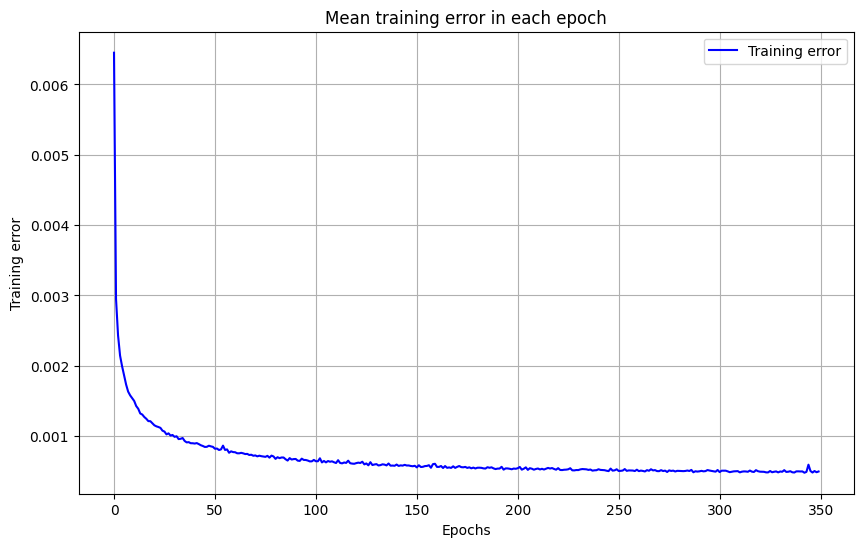

In [245]:
# In this cell, we plot the training error for each epoch

def plot_training_error(loss_for_epochs, custom_begin=100):
    """
    Plot the training error for each epoch.

    Parameters:
    - loss_for_epochs: Array of training errors for each epoch.
    - custom_begin: Epoch to start plotting from (default is 100).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(custom_begin, len(loss_for_epochs)), loss_for_epochs[custom_begin:], label='Training error', color='b')
    plt.title('Mean training error in each epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Training error')
    plt.legend()
    plt.grid(True)
    
    output_image = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}_epochs.png")
    # 文件名格式

    # 保存图像为 PNG 文件
    plt.savefig(output_image)
    
    plt.show()
    
plot_training_error(loss_for_epochs, 0)

In [246]:
# In this cell, we compute the predictions for the entire dataset using the trained model

def compute_predictions(model, u_expanded, y_expanded, total_sample, total_temporal_steps, n_points, batch_size, device):
    """
    Compute predictions for the entire dataset using the trained model.

    Parameters:
    - model: The trained model.
    - u_expanded: Expanded tensor of initial conditions.
    - y_expanded: Expanded tensor of spatial and temporal grid points.
    - total_sample: Total number of samples.
    - total_temporal_steps: Total number of temporal steps.
    - n_points: Number of spatial points.
    - batch_size: Batch size for processing.
    - device: Device to run the computations on (CPU or GPU).

    Returns:
    - all_predictions: Tensor containing predictions for the entire dataset.
    """
    all_predictions = torch.zeros((total_sample, total_temporal_steps * n_points))
    with torch.no_grad():
        for i in tqdm(range(0, total_sample, batch_size), desc="Computing predictions"):
            u_batch = u_expanded[i:i + batch_size].to(device)

            y_batch = y_expanded[i:i + batch_size].to(device)
            prediction = model(u_batch, y_batch).squeeze()
            all_predictions[i:i + batch_size] = prediction.cpu()  # Store predictions and move to CPU
            
            del u_batch, y_batch, prediction
            torch.cuda.empty_cache()  # Release cache for the current batch

    return all_predictions

all_predictions = compute_predictions(model, u_expanded, y_expanded, total_sample, total_temporal_steps, n_points, 25, device)

Computing predictions:   0%|          | 0/20 [00:00<?, ?it/s]

In [247]:
# In this cell, we compute the relative L2 error for the entire dataset, including training and testing sets

# 定义对最后一维计算 L2 范数的函数
def l2_norm_last_coord_torch(tensor):
    return torch.norm(tensor, p=2, dim=-1)

absolute_err = torch.zeros((total_sample,total_temporal_steps*n_points))
absolute_l2_err = np.zeros(total_sample)
relative_l2_err = np.zeros(total_sample)
for i in tqdm(range(total_sample), desc="Computing relative l2 error for the entire dataset"):
    absolute_err[i] = abs(all_predictions[i] - s_tensor[i])
    absolute_l2_err[i] = l2_norm_last_coord_torch(absolute_err[i])
    relative_l2_err[i] = absolute_l2_err[i] / l2_norm_last_coord_torch(s_tensor[i])

train_relative_l2_err = relative_l2_err[:border]
test_relative_l2_err = relative_l2_err[border:]

Computing relative l2 error for the entire dataset:   0%|          | 0/500 [00:00<?, ?it/s]

In [248]:
# In this cell, we compute the key statistics of the relative L2 error for the training and testing sets, and compare the statistics

# 计算张量的统计量
def get_statistics(array):
    stats = {
        'mean': np.mean(array),
        'std': np.std(array),
        'min': np.min(array),
        'median': np.median(array),
        'max': np.max(array)
    }
    return stats

# 比较两个张量的统计量
def compare_statistics(statistics1, statistics2, output_file):
    comparison = {}
    for key in statistics1.keys():
        comparison[key] = {
            'train': statistics1[key],
            'test': statistics2[key],
            'difference': statistics1[key] - statistics2[key]  # 计算差异
        }

    with open(output_file, 'w') as f:
        f.write("\nComparison of Train and Test Statistics:\n")
        print("\nComparison of Train and Test Statistics:\n")
        for key, values in comparison.items():
            f.write(f"{key}: Train = {values['train']}, Test = {values['test']}, Absolute Difference = {abs(values['difference'])}\n")
            print(f"{key}: Train = {values['train']}, Test = {values['test']}, Absolute Difference = {abs(values['difference'])}")

# 获取训练和测试张量的统计量
train_statistics = get_statistics(train_relative_l2_err)
test_statistics = get_statistics(test_relative_l2_err)

# 比较两个统计量并打印结果
compare_statistics(train_statistics, test_statistics, model_stat_file)


Comparison of Train and Test Statistics:

mean: Train = 0.1101794823165983, Test = 0.17275303706526757, Absolute Difference = 0.06257355474866927
std: Train = 0.024253155085067486, Test = 0.06977465779270887, Absolute Difference = 0.04552150270764139
min: Train = 0.05730240046977997, Test = 0.0703788623213768, Absolute Difference = 0.013076461851596832
median: Train = 0.11025553196668625, Test = 0.15894243121147156, Absolute Difference = 0.04868689924478531
max: Train = 0.17672666907310486, Test = 0.5377048254013062, Absolute Difference = 0.3609781563282013


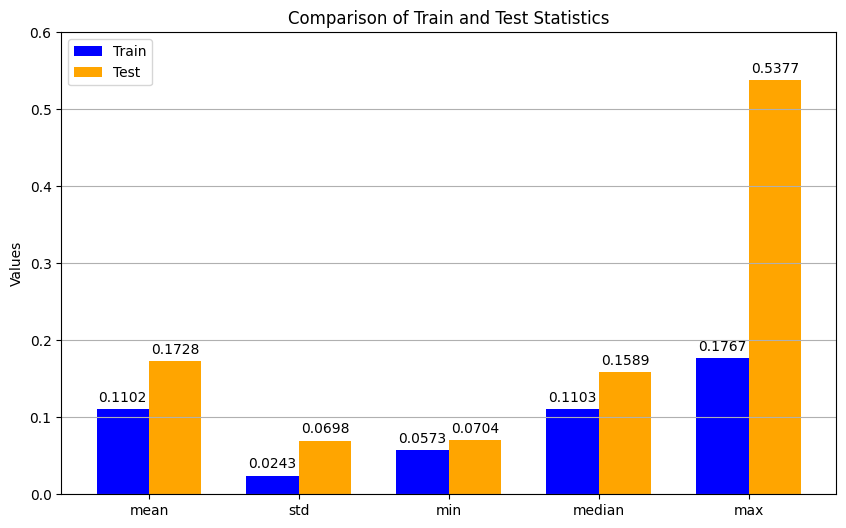

In [249]:
import matplotlib.pyplot as plt
import numpy as np

def plot_statistics_comparison(train_statistics, test_statistics, y_limit=None):
    """
    Plot the comparison of train and test statistics in a bar chart.

    Parameters:
    - train_statistics: Dictionary of training statistics.
    - test_statistics: Dictionary of testing statistics.
    - y_limit: Limit for the y-axis.
    """
    # Extract statistics data for plotting
    labels = list(train_statistics.keys())
    train_values = [train_statistics[key] for key in labels]
    test_values = [test_statistics[key] for key in labels]

    # Set up the plot
    bar_positions = np.arange(len(labels))  # Number of labels
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(bar_positions - width/2, train_values, width, label='Train', color='b')
    bars2 = ax.bar(bar_positions + width/2, test_values, width, label='Test', color='orange')

    # Add labels and title
    ax.set_ylabel('Values')
    ax.set_title('Comparison of Train and Test Statistics')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(labels)
    ax.legend()

    # Set y-axis limit if provided
    if y_limit:
        ax.set_ylim(y_limit)

    # Add data labels with more decimal points
    def add_data_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',  # Keep four decimal places
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset upwards
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_data_labels(bars1)
    add_data_labels(bars2)

    plt.grid(axis='y')

    output_image = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}_statplot.png")
    # 文件名格式
    # 保存图像为 PNG 文件
    plt.savefig(output_image)

    plt.show()

# Example usage with y-axis limit
plot_statistics_comparison(train_statistics, test_statistics, y_limit=(0, 0.6))

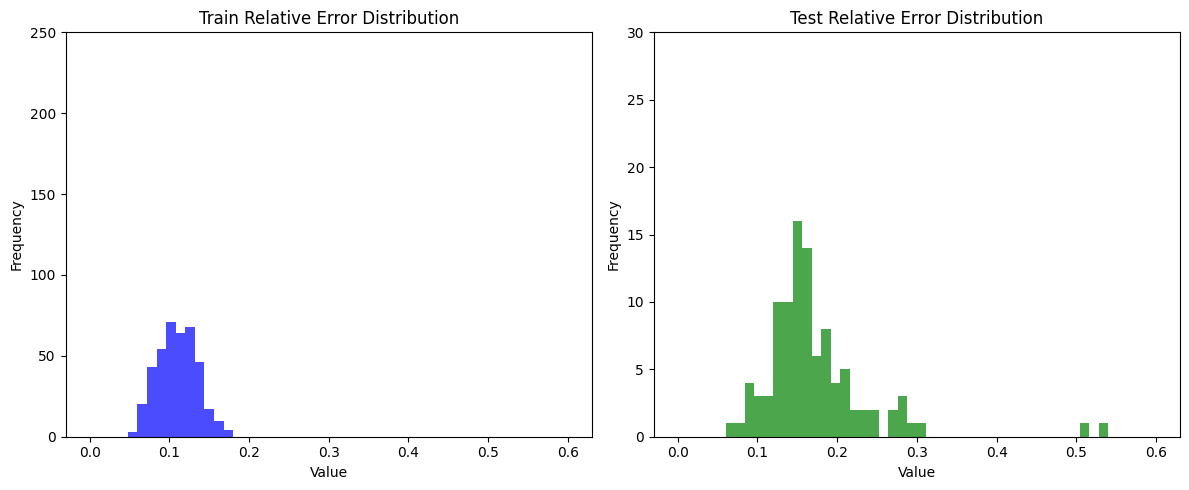

In [250]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_dual_histogram(array1, array2, bins=50, x_range=(0, 0.6), y_limit1=None, y_limit2=None, color1='blue', color2='green',
                        title1='Train Relative Error Distribution', title2='Test Relative Error Distribution'):
    """
    Plot two 1D array histograms side by side.
    Parameters:
    - array1: Data for the first array.
    - array2: Data for the second array.
    - bins: Number of bins for the histogram.
    - x_range: Range of the histogram.
    - y_limit1: Limit for the y-axis of the first histogram.
    - y_limit2: Limit for the y-axis of the second histogram.
    - color1: Color for the first histogram.
    - color2: Color for the second histogram.
    - title1: Title for the first histogram.
    - title2: Title for the second histogram.
    """
    # Create two subplots for the histograms
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram
    axs[0].hist(array1, bins=bins, range=x_range, alpha=0.7, color=color1)
    axs[0].set_title(title1)
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    if y_limit1:
        axs[0].set_ylim(y_limit1)

    # Plot the second histogram
    axs[1].hist(array2, bins=bins, range=x_range, alpha=0.7, color=color2)
    axs[1].set_title(title2)
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')
    if y_limit2:
        axs[1].set_ylim(y_limit2)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Define the output image path
    output_image = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}_hist.png")

    # Save the plot as a PNG file
    plt.savefig(output_image)

    # Show the plot
    plt.show()

plot_dual_histogram(train_relative_l2_err, test_relative_l2_err, y_limit1=(0, 250), y_limit2=(0, 30))

In [251]:
time_list_path = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}-time.npy")
time_list = np.load(time_list_path)
time_mean = np.mean(time_list, axis=-1)

time_output = os.path.join(model_train_directory, f"{problem}_Var{var}_Visc{visc}_Struct{struct}_Sensor{n_points}_Boundary{boundary_parameter}_Initial{initial_parameter}_Batch{train_batch_size}_time.txt")
with open(time_output, 'w') as f:
    f.write(f"The training time for each epoch is: {time_mean:.6f} seconds.")
    print(f"The training time for each epoch is: {time_mean:.6f} seconds.")

The training time for each epoch is: 52.519311 seconds.
